In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data.csv")
print(df.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [3]:
df = pd.read_csv("data.csv")
df = df.drop(columns=['country'])  # drop 'country' column completely

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [4]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

In [6]:
X = df.values.astype(float)
print(X)

[[9.02e+01 1.00e+01 7.58e+00 ... 5.62e+01 5.82e+00 5.53e+02]
 [1.66e+01 2.80e+01 6.55e+00 ... 7.63e+01 1.65e+00 4.09e+03]
 [2.73e+01 3.84e+01 4.17e+00 ... 7.65e+01 2.89e+00 4.46e+03]
 ...
 [2.33e+01 7.20e+01 6.84e+00 ... 7.31e+01 1.95e+00 1.31e+03]
 [5.63e+01 3.00e+01 5.18e+00 ... 6.75e+01 4.67e+00 1.31e+03]
 [8.31e+01 3.70e+01 5.89e+00 ... 5.20e+01 5.40e+00 1.46e+03]]


In [7]:
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
print(X)

[[0.42648491 0.04948197 0.35860783 ... 0.47534517 0.73659306 0.00307343]
 [0.06815969 0.13953104 0.29459291 ... 0.87179487 0.07886435 0.03683341]
 [0.12025316 0.1915594  0.14667495 ... 0.87573964 0.27444795 0.04036499]
 ...
 [0.10077897 0.35965101 0.31261653 ... 0.8086785  0.12618297 0.01029885]
 [0.26144109 0.1495365  0.20944686 ... 0.69822485 0.55520505 0.01029885]
 [0.39191821 0.18455558 0.25357365 ... 0.39250493 0.670347   0.01173057]]


In [8]:
def kmeans(X, k, max_iters=100):
    np.random.seed(42)

    # Randomly initialize centroids
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for _ in range(max_iters):
        # Step 1: Assign clusters
        clusters = []
        for x in X:
            distances = [np.linalg.norm(x - centroid) for centroid in centroids]
            clusters.append(np.argmin(distances))
        clusters = np.array(clusters)

        # Step 2: Update centroids
        new_centroids = []
        for i in range(k):
            cluster_points = X[clusters == i]
            new_centroid = cluster_points.mean(axis=0)
            new_centroids.append(new_centroid)

        new_centroids = np.array(new_centroids)

        # Stop if centroids do not change
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return clusters, centroids

In [37]:
k = 5
labels, centroids = kmeans(X, k)


In [10]:
df["Cluster"] = labels
print(df.head())
print("\nCentroids:\n", centroids)

   child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  Cluster  
0       5.82    553        1  
1       1.65   4090        0  
2       2.89   4460        0  
3       6.16   3530        1  
4       2.13  12200        0  

Centroids:
 [[0.09683936 0.20198974 0.27547631 0.27171294 0.09675525 0.10913815
  0.79600535 0.18385366 0.06133856]
 [0.44855566 0.14374556 0.27839238 0.24371101 0.0236866  0.15178408
  0.53732194 0.62446547 0.01406841]
 [0.01118375 0.29177116 0.44172956 0.29575955 0.36332096 0.0623325
  0.94961961 0.0932402  0.40934   ]]


In [13]:
def inertia(X, labels, centroids):
    total = 0
    for i in range(len(X)):
        total += np.sum((X[i] - centroids[labels[i]]) ** 2)
    return total

In [40]:
print("intertia ",inertia(X, labels, centroids) )

intertia  15.409995076194294


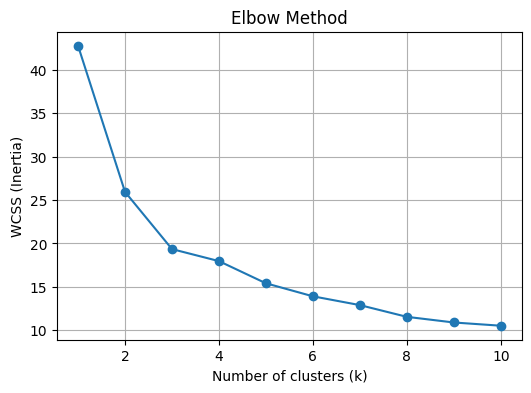

In [14]:
k_values = range(1, 11)
wcss = []

for k in k_values:
    labels, centroids = kmeans(X, k)
    wcss.append(inertia(X, labels, centroids))

plt.figure(figsize=(6,4))
plt.plot(k_values, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()


In [38]:
def silhouette(X, labels):
    n = len(X)
    unique_clusters = np.unique(labels)
    silhouette_vals = []

    for i in range(n):
        same_cluster = labels == labels[i]
        other_clusters = labels != labels[i]

        # a = intra-cluster distance
        if np.sum(same_cluster) > 1:
            a = np.mean([np.linalg.norm(X[i] - X[j])
                         for j in range(n) if same_cluster[j] and j != i])
        else:
            a = 0

        # b = nearest-cluster distance
        b = np.inf
        for cluster in unique_clusters:
            if cluster != labels[i]:
                cluster_points = X[labels == cluster]
                dist = np.mean([np.linalg.norm(X[i] - p) for p in cluster_points])
                b = min(b, dist)

        s = (b - a) / max(a, b)
        silhouette_vals.append(s)

    return np.mean(silhouette_vals)





In [39]:
print("Silhouette Score:", silhouette(X, labels))


Silhouette Score: 0.3051648693143097
